# Classification

Classification Problem - Amongst cases that made a bail plea, bail granted or not. 

### Data Pre-processing

So in the pre-processing part, I take all the cases data from cases_20xx tables. I filter out for only those cases whose disposition resulted in either 'bail granted' or 'bail rejected' i.e., the cases that made a bail plea.

I then split all the column that contains data into three other integer columns in hopes that these might act as useful features while training the model.

I drop all the columns like 'ddl_case_id','cino' since I was pretty sure these columns would not have any co-relation with the judgement results. I also drop gender related columns because I dont think those will have any co-relation either.

I lastly drop the disp_name column because it is what I am trying to classifying and if I dont drop it I will 100% accuray (lol).

I add a new column 'target_y' which is True if bail was granted and False if bail was rejected. (I also remove this column before training ofcourse xP).


In [2]:
paths = {
    "cases_2010" : "./data/cases/cases_2010.csv",
    "cases_2011" : "./data/cases/cases_2011.csv",
    "cases_2012" : "./data/cases/cases_2012.csv",
    "cases_2013" : "./data/cases/cases_2013.csv",
    "cases_2014" : "./data/cases/cases_2014.csv",
    "cases_2015" : "./data/cases/cases_2015.csv",
    "cases_2016" : "./data/cases/cases_2016.csv",
    "cases_2017" : "./data/cases/cases_2017.csv",
    "cases_2018" : "./data/cases/cases_2018.csv",
    "judges" : "./data/judges_clean/judges_clean.csv",
    "judges_key" : "./data/keys/judge_case_merge_key.csv",
    "cases_state_key" : "./data/keys/cases_state_key.csv",
    "type_name_key" : "./data/keys/type_name_key.csv",
    "act_key"         :     "./data/keys/act_key.csv",
    "acts_sections" : "./data/acts_sections/acts_sections.csv",
    "section_key"     :     "./data/section_key.csv"
}

years = [2010, 2011, 2012, 2013 ,2014,2015 ,2016, 2017,2018]
cases = ["cases_2010","cases_2011","cases_2012", "cases_2013","cases_2014","cases_2015","cases_2016","cases_2017","cases_2018"]

import polars as pl
df = pl.read_csv(paths['cases_2010'],parse_dates=True)
list = [8,9]
df = df.filter(pl.col(['disp_name']).is_in(list))
for i in range(1,len(cases)):
    x = pl.read_csv(paths[cases[i]],parse_dates=True)
    x = x.filter(pl.col(['disp_name']).is_in(list))
    df = pl.concat([df,x])
df = df.drop_nulls()

def d(x):
    try:
        return x.day
    except:
        return 0

def m(x):
    try:
        return x.month
    except:
        return 0

def y(x):
    try:
        return x.year
    except:
        return 0

df = df.with_columns([
    (pl.col("date_next_list").apply(d)).alias("date_next_list_d"),
    (pl.col("date_next_list").apply(m)).alias("date_next_list_m"),
    (pl.col("date_next_list").apply(y)).alias("date_next_list_y"),

    (pl.col("date_last_list").apply(d)).alias("date_last_list_d"),
    (pl.col("date_last_list").apply(m)).alias("date_last_list_m"),
    (pl.col("date_last_list").apply(y)).alias("date_last_list_y"),

    (pl.col("date_first_list").apply(d)).alias("date_first_list_d"),
    (pl.col("date_first_list").apply(m)).alias("date_first_list_m"),
    (pl.col("date_first_list").apply(y)).alias("date_first_list_y"),

    (pl.col("date_of_decision").apply(d)).alias("date_of_decision_d"),
    (pl.col("date_of_decision").apply(m)).alias("date_of_decision_m"),
    (pl.col("date_of_decision").apply(y)).alias("date_of_decision_y"),

    (pl.col("date_of_filing").apply(d)).alias("date_of_filing_d"),
    (pl.col("date_of_filing").apply(m)).alias("date_of_filing_m"),
    (pl.col("date_of_filing").apply(y)).alias("date_of_filing_y"),
])

df = df.drop(["date_next_list","date_last_list","date_first_list","date_of_decision","date_of_filing"])

df = df.with_column(pl.col('disp_name').apply(lambda x : x == 8).alias("target_y"))

df =df.drop(['ddl_case_id','cino'])
df = df.drop(['female_defendant','female_petitioner','female_adv_def','female_adv_pet','judge_position'])
df =df.drop(['disp_name'])


# Training

Here I am using Naive Bayes Model to train the data. I am training on 80% of the data and then will test on the remaining 20%. Good thing about the train_test_split() function is that it well shuffles the data before spliting.

In [22]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(df[['year','state_code','dist_code','court_no','type_name','purpose_name','date_next_list_d','date_next_list_m','date_next_list_y','date_last_list_d','date_last_list_m','date_last_list_y','date_first_list_d','date_first_list_m','date_first_list_y','date_of_decision_d','date_of_decision_m','date_of_decision_y','date_of_filing_d','date_of_filing_m','date_of_filing_y']], df['target_y'],test_size=0.2)

from sklearn.naive_bayes import GaussianNB
import numpy as np

clf = GaussianNB()

X_encoded = X_train
y_train = pl.DataFrame(y_train)

# print(X_encoded,y_train)

clf.fit(X_encoded.to_numpy(), y_train.to_numpy().ravel())

GaussianNB()

# Testing

So I test the trained model on remaining 20% of the data. I get the predicted classes for test cases and compare them with actual y classes using various scores like precision_score, recall_score, f1_score , roc_auc_score, accuracy_score.

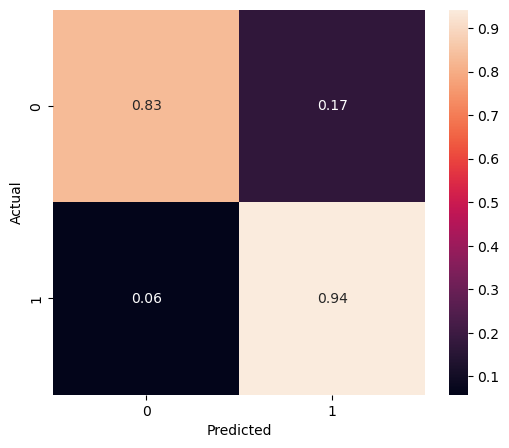

Confusion Matrix = 
 [[0.83050847 0.16949153]
 [0.05796335 0.94203665]]
precision_score =  0.9990657698056801
recall_score =  0.9420366455250176
f1_score =  0.9697134566557852
accuracy_score =  0.9414599947419157
roc_auc_score =  0.8862725600506445


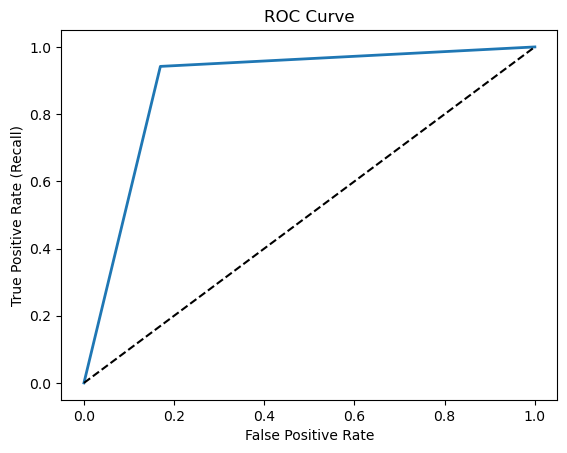

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = clf.predict(X_test.to_numpy())
x = confusion_matrix(y_test, y_train_pred)

import seaborn as sns
import matplotlib.pyplot as plt

# Normalise
x = x.astype('float') / x.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(x, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Confusion Matrix = \n",x)

from sklearn.metrics import precision_score, recall_score, f1_score , roc_auc_score, accuracy_score
a = precision_score(y_test, y_train_pred) 
b = recall_score(y_test, y_train_pred)
c = f1_score(y_test, y_train_pred)
d = accuracy_score(y_test, y_train_pred)
e = roc_auc_score(y_test, y_train_pred)
print("precision_score = ",a)
print("recall_score = ",b)
print("f1_score = ",c)
print("accuracy_score = ",d)
print("roc_auc_score = ",e)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_train_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

### Analyzing Performance

The Model seems pretty good. It has Accuray around 0.94 and pretty good precision,recall and f1 scores

Here precision is better than recall. That means the model is better at recognising True Positives over True Negatives

The confusion Matrix looks pretty neat.

And so does the roc curve looks like this.

I found Naive Bayes classifier to give the best result. 

Some other models that I tried were - SVC, Ramdom Forest and Decision Tree. The code for all of them is the same with the cls initialization part being different with different import statements.

#### SVC

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(df[['year','state_code','dist_code','court_no','type_name','purpose_name','date_next_list_d','date_next_list_m','date_next_list_y','date_last_list_d','date_last_list_m','date_last_list_y','date_first_list_d','date_first_list_m','date_first_list_y','date_of_decision_d','date_of_decision_m','date_of_decision_y','date_of_filing_d','date_of_filing_m','date_of_filing_y']], df['target_y'],test_size=0.2)

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

X_encoded = X_train
y_train = pl.DataFrame(y_train)

# print(X_encoded,y_train)

clf.fit(X_encoded.to_numpy(), y_train.to_numpy().ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

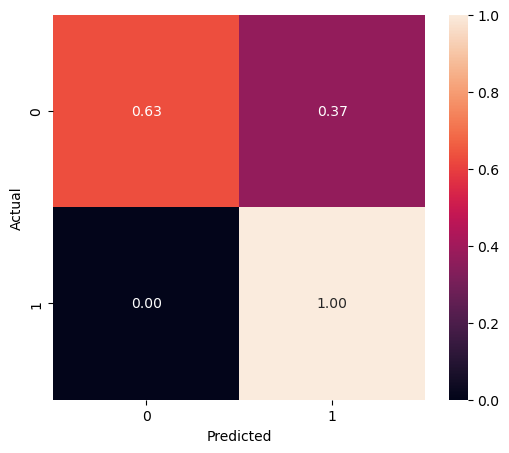

Confusion Matrix = 
 [[0.62913907 0.37086093]
 [0.         1.        ]]
precision_score =  0.9975359704316452
recall_score =  1.0
f1_score =  0.9987664654830609
accuracy_score =  0.9975462273245115
roc_auc_score =  0.814569536423841


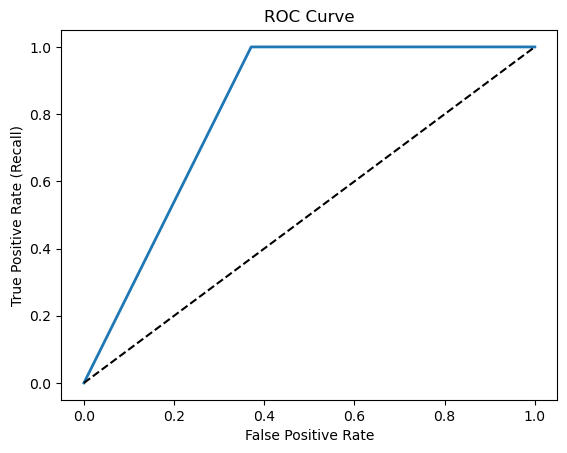

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = clf.predict(X_test.to_numpy())
x = confusion_matrix(y_test, y_train_pred)

import seaborn as sns
import matplotlib.pyplot as plt

# Normalise
x = x.astype('float') / x.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(x, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Confusion Matrix = \n",x)

from sklearn.metrics import precision_score, recall_score, f1_score , roc_auc_score, accuracy_score
a = precision_score(y_test, y_train_pred) 
b = recall_score(y_test, y_train_pred)
c = f1_score(y_test, y_train_pred)
d = accuracy_score(y_test, y_train_pred)
e = roc_auc_score(y_test, y_train_pred)
print("precision_score = ",a)
print("recall_score = ",b)
print("f1_score = ",c)
print("accuracy_score = ",d)
print("roc_auc_score = ",e)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_train_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

#### Random Forest Classifier

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(df[['year','state_code','dist_code','court_no','type_name','purpose_name','date_next_list_d','date_next_list_m','date_next_list_y','date_last_list_d','date_last_list_m','date_last_list_y','date_first_list_d','date_first_list_m','date_first_list_y','date_of_decision_d','date_of_decision_m','date_of_decision_y','date_of_filing_d','date_of_filing_m','date_of_filing_y']], df['target_y'],test_size=0.2)

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np

clf = RandomForestClassifier(max_depth=2, random_state=0)

X_encoded = X_train
y_train = pl.DataFrame(y_train)

# print(X_encoded,y_train)

clf.fit(X_encoded.to_numpy(), y_train.to_numpy().ravel())

RandomForestClassifier(max_depth=2, random_state=0)

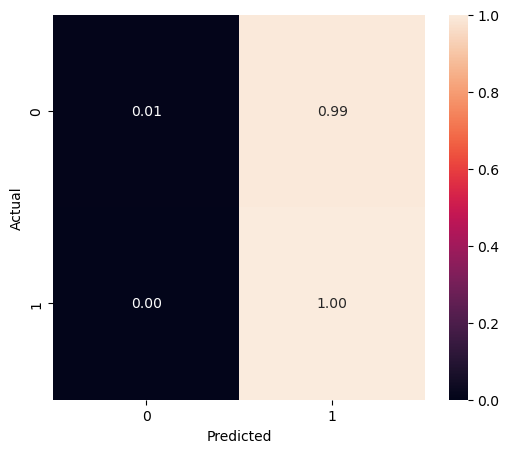

Confusion Matrix = 
 [[0.00645161 0.99354839]
 [0.         1.        ]]
precision_score =  0.9932518294553262
recall_score =  1.0
f1_score =  0.9966144917340838
accuracy_score =  0.9932521251424065
roc_auc_score =  0.5032258064516129


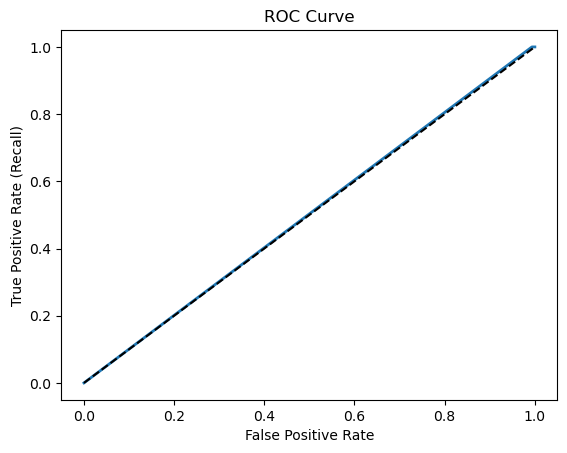

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = clf.predict(X_test.to_numpy())
x = confusion_matrix(y_test, y_train_pred)

import seaborn as sns
import matplotlib.pyplot as plt

# Normalise
x = x.astype('float') / x.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(x, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Confusion Matrix = \n",x)

from sklearn.metrics import precision_score, recall_score, f1_score , roc_auc_score, accuracy_score
a = precision_score(y_test, y_train_pred) 
b = recall_score(y_test, y_train_pred)
c = f1_score(y_test, y_train_pred)
d = accuracy_score(y_test, y_train_pred)
e = roc_auc_score(y_test, y_train_pred)
print("precision_score = ",a)
print("recall_score = ",b)
print("f1_score = ",c)
print("accuracy_score = ",d)
print("roc_auc_score = ",e)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_train_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

#### Decision Tree Classifier

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(df[['year','state_code','dist_code','court_no','type_name','purpose_name','date_next_list_d','date_next_list_m','date_next_list_y','date_last_list_d','date_last_list_m','date_last_list_y','date_first_list_d','date_first_list_m','date_first_list_y','date_of_decision_d','date_of_decision_m','date_of_decision_y','date_of_filing_d','date_of_filing_m','date_of_filing_y']], df['target_y'],test_size=0.2)

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

clf = DecisionTreeClassifier(random_state=0)

X_encoded = X_train
y_train = pl.DataFrame(y_train)

# print(X_encoded,y_train)

clf.fit(X_encoded.to_numpy(), y_train.to_numpy().ravel())

DecisionTreeClassifier(random_state=0)

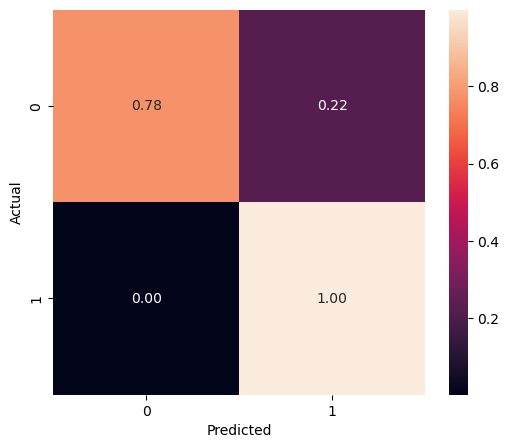

Confusion Matrix = 
 [[0.7755102  0.2244898 ]
 [0.00176406 0.99823594]]
precision_score =  0.9985442032821599
recall_score =  0.9982359426681368
f1_score =  0.9983900491806894
accuracy_score =  0.9968013320480238
roc_auc_score =  0.8868730733748846


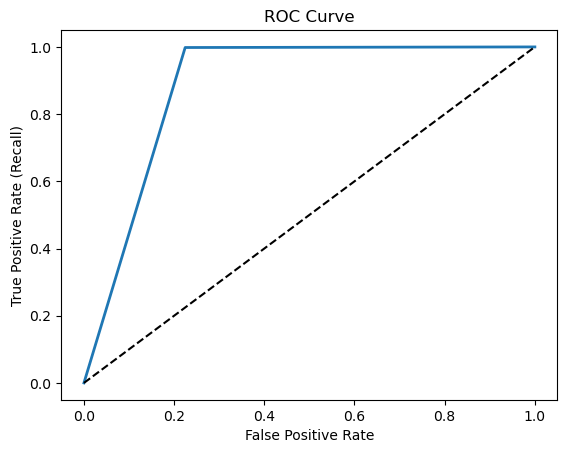

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = clf.predict(X_test.to_numpy())
x = confusion_matrix(y_test, y_train_pred)

import seaborn as sns
import matplotlib.pyplot as plt

# Normalise
x = x.astype('float') / x.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(x, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Confusion Matrix = \n",x)

from sklearn.metrics import precision_score, recall_score, f1_score , roc_auc_score, accuracy_score
a = precision_score(y_test, y_train_pred) 
b = recall_score(y_test, y_train_pred)
c = f1_score(y_test, y_train_pred)
d = accuracy_score(y_test, y_train_pred)
e = roc_auc_score(y_test, y_train_pred)
print("precision_score = ",a)
print("recall_score = ",b)
print("f1_score = ",c)
print("accuracy_score = ",d)
print("roc_auc_score = ",e)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_train_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

### Inferences


* Naive Bayes gave the best results with a pretty good roc score. 
* Random Forest was the worst, It kept guessing only one class(as evident from confusion matrix) and there was no learning at all.
* Decision Tree is pretty good too with its roc score nearing Naive Bayes and a high accuracy. Infact its accuracy was sometimes higher than Naive Bayes


* In all the three cases, the bottom right square of the confusion was always denser than the top left. i.e.,all the model is better at recognising True Positives over True Negatives

* Therefore, some kind of corelation _does_ exist between between bail and the other features of the data.